In [1]:
# Make my plots pretty!
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.dpi'] = 100

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Feature Extraction Part 3

Yesterday's experiments seems to yield good features. I have one more trick up my sleeve as far as feature generation is concerned: combining tf-idf and word embeddings.

Then we'll try some other classification methods like random forests and XGBoost.

I'll also refactor some of my code into python functions that can be reused.

In [2]:
# Just load the small training/validation sets we made, no need the whole model.
import pickle
train_set = pickle.load(open('../data/train_small.pickle', 'r'))
valid_set = pickle.load(open('../data/valid_small.pickle', 'r'))
print(len(train_set))
print(len(valid_set))

20000
5000


In [3]:
import torch
import data

In [4]:
# Load word embeddings. 100d to be quick
import sys
sys.path.append('../models/')
import data
reload(data)

dictionary, lookup, embed = data.load_embeddings('../data/glove.6B.100d.txt', max_words=15000)

In [5]:
embed.weight[:100]

Variable containing:
-3.8194e-02 -2.4487e-01  7.2812e-01  ...  -1.4590e-01  8.2780e-01  2.7062e-01
-1.0767e-01  1.1053e-01  5.9812e-01  ...  -8.3155e-01  4.5293e-01  8.2577e-02
-3.3979e-01  2.0941e-01  4.6348e-01  ...  -2.3394e-01  4.7298e-01 -2.8803e-02
                ...                   ⋱                   ...                
-7.9588e-02  1.0425e+00  1.1980e+00  ...  -6.5562e-01  7.9654e-01  3.7697e-01
-9.2921e-03  1.8686e-01  8.4314e-02  ...   7.0178e-01  5.6552e-01 -4.3409e-01
 3.2396e-01  5.9810e-01  1.2378e+00  ...   1.0485e-01  4.9419e-01  3.0868e-01
[torch.FloatTensor of size 100x100]

In [6]:
# Sentence to word embedding indices.
reload(data)
q1s, q2s, ys = data.tensorize(train_set[:2000], dictionary)

In [7]:
# Check the results
from torch.autograd import Variable
v = Variable(q1s[:5, :10])

In [8]:
embed(v).size()

torch.Size([5, 10, 100])

# TF-IDF

Let's count TF-IDF on the whole training set.

In [9]:
%time tf = pickle.load(open('tfidf.pickle', 'rb'))

CPU times: user 1.06 s, sys: 16 ms, total: 1.07 s
Wall time: 1.16 s


What does one of these tf-idf vectors look like?

In [10]:
sentence_sparse = tf.transform(['zxlkxdjfs'])
print(max(sentence_sparse.max(), 0.1))

0.1


In [11]:
reload(data)
tfidf_embed = data.convert_tfidf_vectorizer(tf, lookup)

In [12]:
# Try computing it
print(v.size())
wd_v = embed(v)
tf_v = tfidf_embed(v)

print(wd_v.size(), tf_v.size())
tf_v.squeeze()

torch.Size([5, 10])
torch.Size([5, 10, 100]) torch.Size([5, 10, 1])


Variable containing:

Columns 0 to 7 
  1.9423   2.1463   0.1000   0.1000   0.1000  12.3004  12.3004  12.3004
  2.1463   8.9718  11.8304   1.9740   7.6923  12.1181   5.3403   0.1000
  3.9275   8.7711   6.7568   9.1520   0.1000   4.0407   5.7856   0.1000
  2.3178   5.1970   2.6165   0.1000   4.8106   4.4522   6.8567   2.7255
  3.9457   3.3237   0.1000   5.2235   4.1671   0.1000   2.6165   5.0237

Columns 8 to 9 
 12.3004  12.3004
 12.3004  12.3004
 12.3004  12.3004
  5.2735   7.1635
  8.1589   6.2100
[torch.FloatTensor of size 5x10]

In [13]:
# Use this to rescale the tensor
wd_scaled = wd_v * tf_v.repeat(1,1,100)
wd_scaled.size()

torch.Size([5, 10, 100])

In [14]:
# Compare with:
reload(data)
wd_scaled2 = data.get_reweighted_embeddings(tfidf_embed, embed, v)
torch.max(wd_scaled2 - wd_scaled)

Variable containing:
 0
[torch.FloatTensor of size 1]

In [15]:
# Sentence to word embedding indices.
reload(data)
q1_train_all, q2_train_all, y_train = data.tensorize(train_set, dictionary)

In [16]:
q1_valid_all, q2_valid_all, y_valid = data.tensorize(valid_set, dictionary)

In [57]:
print(q1_train_all.size())
print(q2_train_all.size())
print(q2_valid_all.size())
q1_train_all[:3]

torch.Size([20000, 30])
torch.Size([20000, 30])
torch.Size([5000, 30])




Columns 0 to 10 
   102     14      7  14999    188  14998  14998  14998  14998  14998  14998
    14    785  10586      0   2605  11798    661    188  14998  14998  14998
    42   3751    605   8118     41    189    987    188  14998  14998  14998

Columns 11 to 21 
 14998  14998  14998  14998  14998  14998  14998  14998  14998  14998  14998
 14998  14998  14998  14998  14998  14998  14998  14998  14998  14998  14998
 14998  14998  14998  14998  14998  14998  14998  14998  14998  14998  14998

Columns 22 to 29 
 14998  14998  14998  14998  14998  14998  14998  14998
 14998  14998  14998  14998  14998  14998  14998  14998
 14998  14998  14998  14998  14998  14998  14998  14998
[torch.LongTensor of size 3x30]

# Feature Vectors

Now each sentence is encoded as an Lx30 matrix. Let's use the vectorization techniques. The results of each should be a NxD matrix, one row for each training example.

In [59]:
reload(data)
X_train_q1 = data.get_reweighted_embeddings(tfidf_embed, embed, Variable(q1_train_all))
X_train_q2 = data.get_reweighted_embeddings(tfidf_embed, embed, Variable(q2_train_all))
X_valid_q1 = data.get_reweighted_embeddings(tfidf_embed, embed, Variable(q1_valid_all))
X_valid_q2 = data.get_reweighted_embeddings(tfidf_embed, embed, Variable(q2_valid_all))

In [60]:
import features
reload(features)

# The simplest thing would be averaging all the per-word vectors to get a single sentence embedding.
X_train_q1_mean = X_train_q1.mean(dim=1).squeeze()
X_train_q2_mean = X_train_q2.mean(dim=1).squeeze()
X_valid_q1_mean = X_valid_q1.mean(dim=1).squeeze()
X_valid_q2_mean = X_valid_q2.mean(dim=1).squeeze()
print(X_train_q1_mean.size())

torch.Size([20000, 100])


In [61]:
reload(features)
perm = features.Permute(differentiable=False, n_trials=1000, power=0.05)

from_module = []
for trial in xrange(500):
    if trial % 100 == 0:
        print(trial)
    xq1_small = X_train_q1[:2]
    xq2_small = X_train_q2[:2]
    samples, x_small = perm(xq1_small, xq2_small)
    from_module.append(x_small[0,10:20].data.numpy())
from_module = np.stack(from_module, axis=0)
print(from_module.shape)

0
100
200
300
400
(500, 10)


In [94]:
reload(features)
perm = features.Permute(differentiable=True, n_trials=1000, power=0.05)

differentiable_results = []
for trial in xrange(800):
    if trial % 100 == 0:
        print(trial)
    xq1_small = X_train_q1[:2]
    xq2_small = X_train_q2[:2]
    samples, x_small = perm(xq1_small, xq2_small)
    differentiable_results.append(x_small[0,10:20].data.numpy())

0
100
200
300
400
500
600
700


In [53]:
#verification = []
from_md_nps = np.concatenate([from_md_nps, from_module])
print(from_md_nps.shape)

(2500, 10)


In [39]:
verification = []

In [83]:
# Verify implementation
q1 = X_train_q1[0].squeeze()
q2 = X_train_q2[0].squeeze()
print(q1.size())

q1_mean = q1.mean(dim=0)
q2_mean = q2.mean(dim=0)
base_diff = (q1_mean - q2_mean).abs()
len_q1 = q1.size(0)
len_q2 = q2.size(0)
sum_len = len_q1 + len_q2

q1q2 = torch.cat([q1, q2], 0)
print(q1q2.size())
n_permutes = 400
for trial in xrange(100):
    running_diff = Variable(torch.zeros(100))
    if trial % 10 == 0:
        print(trial)
    for t in xrange(n_permutes):
        perm = torch.randperm(sum_len)
        qs1 = q1q2[perm[:len_q1]]
        qs2 = q1q2[perm[len_q1:]]
        qs1_mean = qs1.mean(dim=0)
        qs2_mean = qs2.mean(dim=0)
        diff = (qs1_mean - qs2_mean).abs()
        running_diff.add_((diff > base_diff).squeeze().float())

    val = (running_diff / n_permutes)
    verification.append(val[10:20].data.numpy())

torch.Size([30, 100])
torch.Size([60, 100])
0
10
20
30
40
50
60
70
80
90


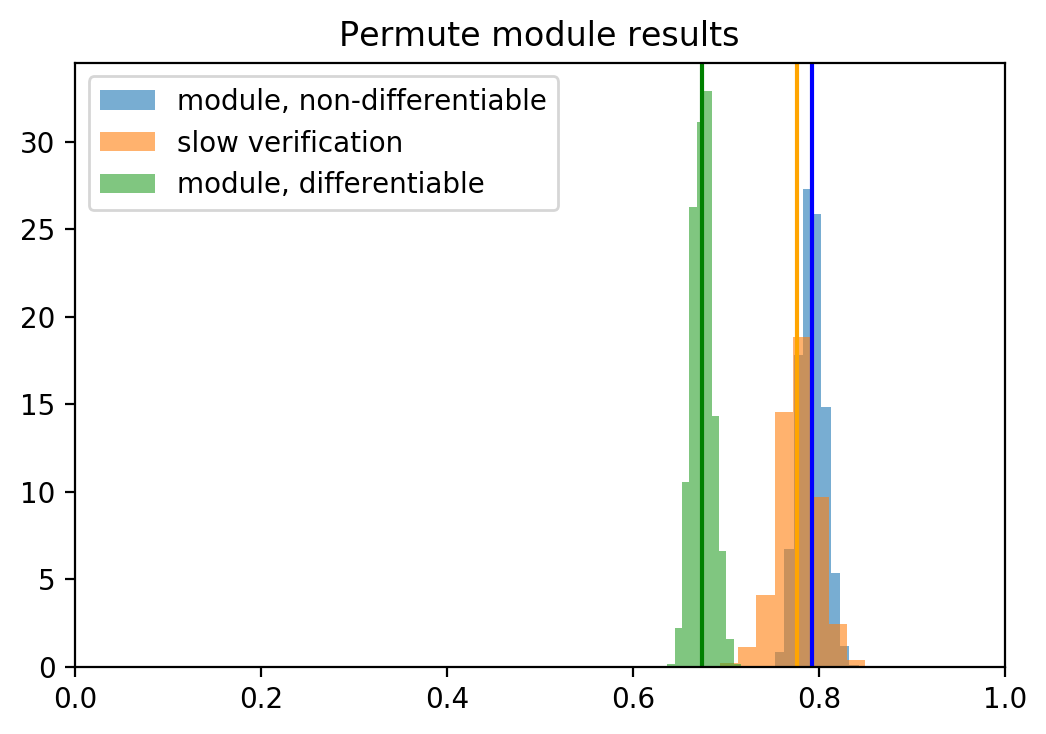

In [112]:
veri_np2 = np.stack(verification)
veri_all = np.concatenate([veri_np2, veri_np * 5])
diffe = np.stack(differentiable_results)
plt.figure()

col = 9
plt.title('Permute module results')
plt.hist(from_md_nps[:,col], 10, alpha=0.6, normed=True, label='module, non-differentiable')
plt.hist(veri_all[:,col], 10, alpha=0.6, normed=True, label='slow verification')
plt.hist(diffe[:,col], 10, alpha=0.6, normed=True, label='module, differentiable')
plt.axvline(x=from_md_nps[:,col].mean(), color='blue')
plt.axvline(x=veri_all[:,col].mean(), color='orange')
plt.axvline(x=diffe[:,col].mean(), color='green')
plt.legend(loc='best')
plt.xlim(0, 1)
plt.show()

In [62]:
reload(features)
xq1_small = X_train_q1[:2]
xq2_small = X_train_q2[:2]
kl_q1_q2 = features.elementwise_kl_div(xq1_small, xq2_small)

In [63]:
def mean_stdev(words, base_std = 0.001):
    return np.mean(words, axis=0), (np.std(words, axis=0) + base_std)

def kld(q1, q2):
    mu1, sig1 = mean_stdev(q1)
    mu2, sig2 = mean_stdev(q2)
    
    return np.log(sig2 / sig1) + \
        (np.square(sig1) + np.square(mu1 - mu2)) / \
        (2 * np.square(sig2)) - 0.5

np.sum(np.square(kld(xq1_small[1].data.numpy(), xq2_small[1].data.numpy()) - kl_q1_q2[1].data.numpy()))

0.0

In [64]:
reload(features)
perm = features.Permute(differentiable=False, n_trials=200)
module = lambda q1, q2: perm(q1, q2)[1]
%time X_valid_permute = features.apply(X_valid_q1, X_valid_q2, module, batchsize=20)

CPU times: user 17.4 s, sys: 384 ms, total: 17.8 s
Wall time: 4.52 s


In [65]:
reload(features)
%time X_train_permute = features.apply(X_train_q1, X_train_q2, module, batchsize=20, print_every=100)

0
100
200
300
400
500
600
700
800
900
1000
CPU times: user 1min 10s, sys: 1.58 s, total: 1min 11s
Wall time: 18.5 s


In [66]:
X_train_permute.size()

torch.Size([20000, 100])

In [67]:
X_train_kl12 = features.apply(X_train_q1, X_train_q2, features.elementwise_kl_div, print_every=100)
X_valid_kl12 = features.apply(X_valid_q1, X_valid_q2, features.elementwise_kl_div, print_every=100)

0
100
200
300
400
0
100


In [68]:
X_train_kl21 = features.apply(X_train_q2, X_train_q1, features.elementwise_kl_div, print_every=100)
X_valid_kl21 = features.apply(X_valid_q2, X_valid_q1, features.elementwise_kl_div, print_every=100)

0
100
200
300
400
0
100


In [69]:
X_train_kls = features.apply(X_train_q1, X_train_q2, features.symmetric_kl_div, print_every=100)
X_valid_kls = features.apply(X_valid_q1, X_valid_q2, features.symmetric_kl_div, print_every=100)

0
100
200
300
400
0
100


In [70]:
valid2 = features.apply(X_valid_q2, X_valid_q1, features.symmetric_kl_div, print_every=100)

0
100


In [71]:
X_valid_kls - valid2

Variable containing:
1.00000e-07 *
 0.0000  0.0000  0.5960  ...   0.0000  0.0000  0.0000
 0.2980  0.2980  0.5960  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.2980  ...   0.0000 -0.2980  0.0000
          ...             ⋱             ...          
-0.2980 -0.2980 -0.8941  ...  -0.2980  0.2980  0.2980
-0.2980 -0.5960 -0.2980  ...   0.0000  0.5960  0.0000
 0.5960  0.0000  0.0000  ...   0.0000  0.0000 -0.2980
[torch.FloatTensor of size 5000x100]

# Back to SVMs (for the last time)

In [72]:
X_train_kl12.size()

torch.Size([20000, 100])

In [73]:
X_train = torch.cat([
    X_train_q1_mean,
    X_train_q2_mean,
    (X_train_q1_mean * X_train_q2_mean),
    X_train_permute,
    X_train_kl12,
    X_train_kl21,
    X_train_kls,
    (X_train_kl12 * X_train_kl21)
], 1)
X_valid = torch.cat([
    X_valid_q1_mean,
    X_valid_q2_mean,
    (X_valid_q1_mean * X_valid_q2_mean),
    X_valid_permute,
    X_valid_kl12,
    X_valid_kl21,
    X_valid_kls,
    (X_valid_kl12 * X_valid_kl21)
], 1)

In [74]:
X_train_np = X_train.data.numpy()
X_valid_np = X_valid.data.numpy()

In [76]:
wagh = {
    'X_train': X_train_np,
    'y_train': y_train,
    'X_valid': X_valid_np,
    'y_valid': y_valid
}
%time pickle.dump(wagh, open('wagh_tfidf.pickle', 'wb'))
!du -sh wagh_tfidf.pickle

CPU times: user 4 s, sys: 192 ms, total: 4.19 s
Wall time: 4.42 s
197M	wagh_tfidf.pickle


In [77]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

nrm = StandardScaler()
X_train_n = nrm.fit_transform(X_train_np)
X_valid_n = nrm.transform(X_valid_np)

In [78]:
bag_num = 100
examples_per_bag = 1000
models = []

def start():
    C=0.2
    indices = range(len(X_train))
    for i in range(bag_num):
        np.random.shuffle(indices)
        i_bag = indices[:examples_per_bag]
        print('Model:', i, i_bag[:10])
        X_bag = X_train_n[i_bag]
        y_bag = y_train[torch.LongTensor(i_bag)].numpy()
        svm = LinearSVC()
        svm.fit(X_bag, y_bag)
        models.append(svm)
time start()

Model: 0 [4419, 11624, 19966, 16396, 17483, 15105, 4053, 7801, 19701, 19664]
Model: 1 [7812, 6961, 12364, 417, 9665, 12266, 13874, 17734, 12140, 13933]
Model: 2 [8317, 13557, 10588, 19737, 11025, 379, 15720, 470, 8627, 16464]
Model: 3 [16767, 653, 2641, 3805, 4106, 5478, 10027, 6076, 145, 4348]
Model: 4 [5422, 10664, 9813, 8420, 6333, 16224, 12232, 5150, 3849, 10224]
Model: 5 [12790, 8655, 1149, 1146, 19252, 12223, 14872, 12086, 11486, 14573]
Model: 6 [14860, 18741, 16747, 6391, 16020, 5013, 2046, 18867, 6469, 7410]
Model: 7 [13736, 1890, 3983, 1036, 3056, 61, 5838, 15820, 15110, 15688]
Model: 8 [15737, 13195, 16888, 17906, 1728, 12113, 1523, 16717, 961, 19365]
Model: 9 [14632, 832, 19973, 6829, 8907, 3790, 753, 15499, 15091, 8716]
Model: 10 [14899, 10674, 12987, 6242, 7030, 10309, 7429, 3446, 11561, 9160]
Model: 11 [13223, 70, 1787, 13361, 14686, 10371, 13404, 12494, 16134, 2623]
Model: 12 [5397, 7847, 1608, 12613, 15125, 19845, 6021, 16910, 10617, 15953]
Model: 13 [14317, 16408, 1004

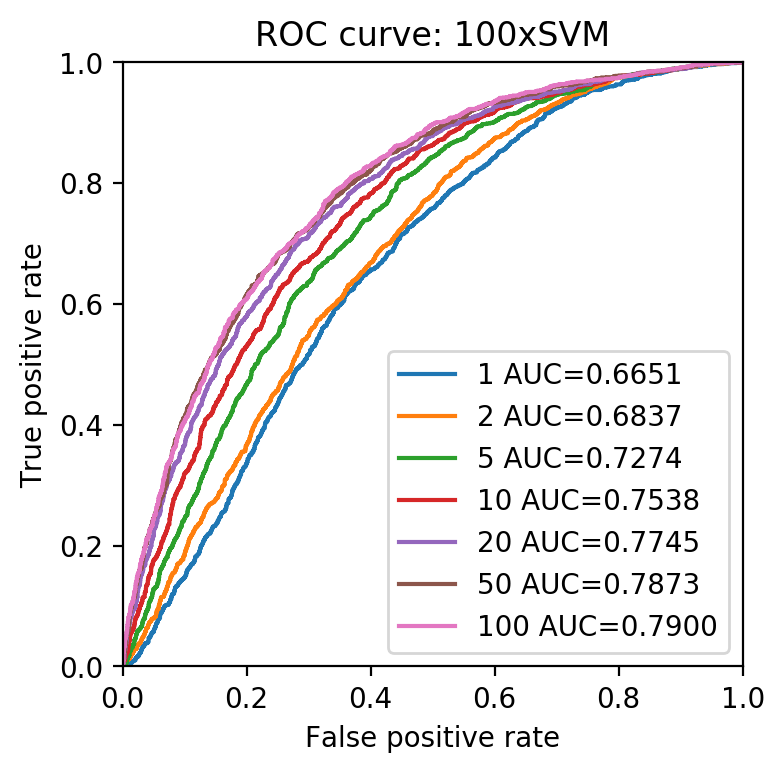

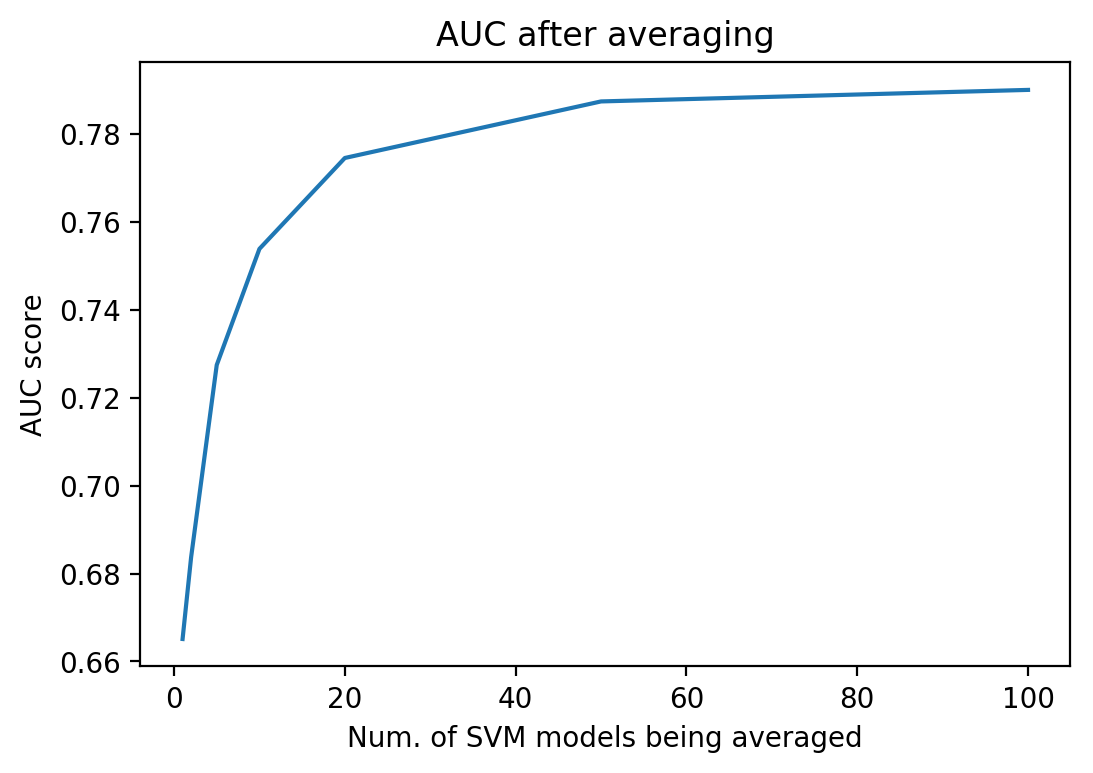

In [91]:
import evaluation
reload(evaluation)

def evaluate_svm(models, X_valid, y_valid, title='', ns=[1, 2, 5, 10, 20, 50, 100]):
    decision_one = lambda svm, x: svm.decision_function(x)
    decisions_array = np.stack([decision_one(svm, X_valid) for svm in models], axis=1)
    evaluation.evaluate_svm(decisions_array, y_valid, title=title, ns=ns)
evaluate_svm(models, X_valid_n, y_valid.numpy(), '100xSVM')

# Random Forest

In [81]:
from sklearn.ensemble import RandomForestClassifier

def learn_tree(estimators):
    tree = RandomForestClassifier(estimators)
    tree.fit(X_train_n, y_train.numpy())
    return tree

tree10 = learn_tree(10)

In [82]:
%time tree20 = learn_tree(20)
%time tree40 = learn_tree(40)
%time tree80 = learn_tree(80)
%time tree100 = learn_tree(100)

CPU times: user 10.8 s, sys: 8 ms, total: 10.8 s
Wall time: 10.8 s
CPU times: user 20.3 s, sys: 0 ns, total: 20.3 s
Wall time: 20.3 s
CPU times: user 40.3 s, sys: 0 ns, total: 40.3 s
Wall time: 40.3 s
CPU times: user 50.8 s, sys: 4 ms, total: 50.8 s
Wall time: 50.8 s


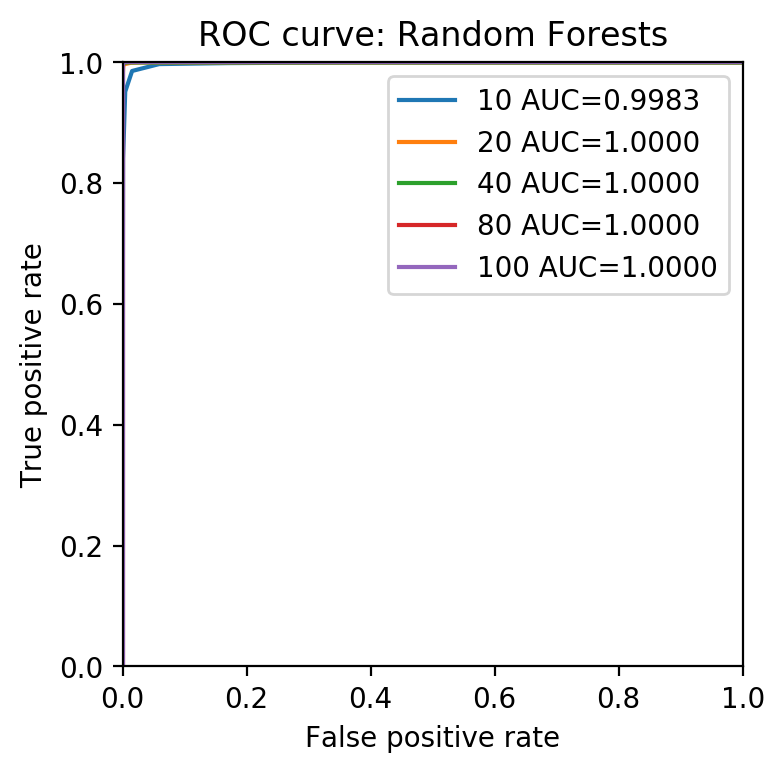

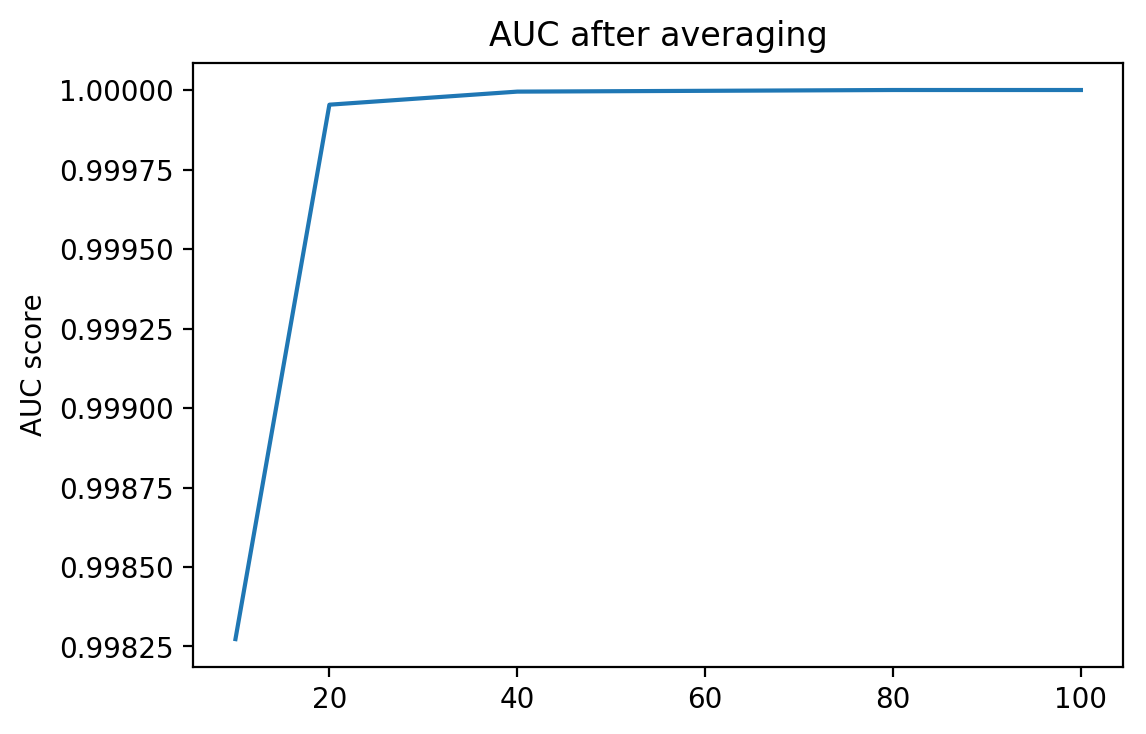

In [96]:
reload(evaluation)
trees = {
    10: tree10,
    20: tree20,
    40: tree40,
    80: tree80,
    100: tree100,
}
def get_tree(n):
    return trees[n].predict_proba(X_valid_n)[:,1]

evaluation.evaluate_results(get_tree, y_valid.numpy(), 'Random Forests', [10, 20, 40, 80, 100])

Um...